In [1]:
import pandas as pd
import networkx as nx
import igviz as ig

In [2]:
characters_df = pd.read_csv('../data/DorianGray/processed_characters.csv')
characters_df

,Unnamed: 0,COREF,start_token,end_token,prop,cat,text,orig_coref,character_name
0,4,112,77,79,PROP,PER,Lord Henry Wotton,112.0,Lord Henry Wotton
1,6,112,156,156,PRON,PER,him,112.0,Lord Henry Wotton
2,14,113,289,290,PROP,PER,Basil Hallward,112.0,Basil Hallward
3,27,113,396,396,PROP,PER,Basil,113.0,Basil Hallward
4,29,112,408,409,PROP,PER,Lord Henry,113.0,Lord Henry Wotton
...,...,...,...,...,...,...,...,...,...
7166,14196,307,95668,95668,PRON,PER,he,NaN,Alan Campbell
7167,14197,307,95674,95674,PRON,PER,He,NaN,Alan Campbell
7168,14215,115,95814,95816,PROP,PER,Mr. Dorian Gray,NaN,Mr. Dorian Gray
7169,14232,268,95885,95885,PROP,PER,Francis,NaN,Francis Osborne


In [3]:
tokens_df = pd.read_csv('../data/DorianGray/character-tagging/DorianGray.tokens', delimiter='\t')
tokens_df

,paragraph_ID,sentence_ID,token_ID_within_sentence,token_ID_within_document,word,lemma,byte_onset,byte_offset,POS_tag,fine_POS_tag,dependency_relation,syntactic_head_ID,event
0,0,0,0,0,The,the,0,3,DET,DT,det,1,O
1,0,0,1,1,studio,studio,4,10,NOUN,NN,nsubjpass,3,O
2,0,0,2,2,was,be,11,14,AUX,VBD,auxpass,3,O
3,0,0,3,3,filled,fill,15,21,VERB,VBN,ROOT,3,O
4,0,0,4,4,with,with,22,26,ADP,IN,prep,3,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96039,1490,6159,11,96039,recognized,recognize,426538,426548,VERB,VBD,relcl,96036,O
96040,1490,6159,12,96040,who,who,426549,426552,PRON,WP,attr,96042,O
96041,1490,6159,13,96041,it,it,426553,426555,PRON,PRP,nsubj,96042,O
96042,1490,6159,14,96042,was,be,426556,426559,AUX,VBD,ccomp,96039,O


In [4]:
# Paragraph based network

characters_paragraph_mention_df = characters_df.copy()
characters_paragraph_mention_df['paragraph'] = characters_paragraph_mention_df.start_token.map(
    lambda x: tokens_df.iloc[x].paragraph_ID
)
characters_paragraph_mention_df

,Unnamed: 0,COREF,start_token,end_token,prop,cat,text,orig_coref,character_name,paragraph
0,4,112,77,79,PROP,PER,Lord Henry Wotton,112.0,Lord Henry Wotton,1
1,6,112,156,156,PRON,PER,him,112.0,Lord Henry Wotton,1
2,14,113,289,290,PROP,PER,Basil Hallward,112.0,Basil Hallward,2
3,27,113,396,396,PROP,PER,Basil,113.0,Basil Hallward,4
4,29,112,408,409,PROP,PER,Lord Henry,113.0,Lord Henry Wotton,4
...,...,...,...,...,...,...,...,...,...,...
7166,14196,307,95668,95668,PRON,PER,he,NaN,Alan Campbell,1483
7167,14197,307,95674,95674,PRON,PER,He,NaN,Alan Campbell,1483
7168,14215,115,95814,95816,PROP,PER,Mr. Dorian Gray,NaN,Mr. Dorian Gray,1486
7169,14232,268,95885,95885,PROP,PER,Francis,NaN,Francis Osborne,1488


In [5]:
paragraph_windows = 10
paragraphs_per_window = characters_paragraph_mention_df.paragraph.max() // paragraph_windows

sizes = paragraph_windows * [paragraphs_per_window]
for i in range(characters_paragraph_mention_df.paragraph.max() - sum(sizes)):
    sizes[i] += 1

In [6]:
graphs = []

G = nx.Graph()

curr_graph = 0

for paragraph, sub_df in characters_paragraph_mention_df.groupby(characters_paragraph_mention_df.paragraph):
    
    if paragraph > sizes[curr_graph] + sum(sizes[:curr_graph]):
        graphs.append(G)
        curr_graph += 1
        G = nx.Graph()
    
    if sub_df.character_name.unique().size == 1:
        continue
    
    pairs = []
    for i, name in enumerate(sub_df.character_name.unique()):
        
        if name not in G.nodes:
            G.add_node(name, connections=sub_df.character_name.unique().size - 1)
        else:
            G.nodes[name]['connections'] += sub_df.character_name.unique().size - 1

        for o_name in sub_df.character_name.unique()[i + 1:]:
            
            if o_name not in G.nodes:
                G.add_node(o_name, connections=0)
            if (name, o_name) not in G.edges:
                G.add_edge(name, o_name, weight=1)
            else:
                G.edges[name, o_name]['weight'] += 1

In [7]:
window = 2

color_list = []
sizing_list = []

G = graphs[window]

for node in G.nodes():
    size_and_color = G.nodes[node]['connections']

    color_list.append(size_and_color)
    sizing_list.append(size_and_color)

ig.plot(
    G,
    title=f"Window {window} Social Network",
    layout="spring",
    size_method=sizing_list, # Makes node sizes the size of the "prop" property
    color_method=color_list, # Colors the nodes based off the "prop" property and a color scale,
    edge_label="weight", # Display the "edge_prop" attribute on the edge
    edge_label_position="bottom center", # Display the edge label below the edge
    node_text=['connections']
)

C:\Users\decla\AppData\Local\Temp\ipykernel_36908\3320986741.py:14: DeprecationWarning: Argument `titlefont_size` is deprecated and will be removed in 0.6.0.
  ig.plot(


FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines+text',
              'text': [],
              'type': 'scatter',
              'uid': '2a7b1924-db54-405e-8159-c5f74eeb71c2',
              'x': [0.009895846472072057, 0.3642237197817924, None,
                    0.009895846472072057, -0.11251449128917804, None,
                    0.009895846472072057, -0.31972902114501495, None,
                    0.009895846472072057, 0.061434338455531, None,
                    0.009895846472072057, 0.07264796009690208, None,
                    0.009895846472072057, 0.3283783779226397, None,
                    0.009895846472072057, 0.19856993326362124, None,
                    0.009895846472072057, -0.03665230343564386, None,
                    0.061434338455531, 0.3283783779226397, None, 0.061434338455531,
                    -0.03665230343564386, None, 0.061434338455531,
                    0.19856993326362124

In [8]:
# Ego Networks

character_of_interest = 'Mr. Dorian Gray'

for graph in graphs:
    remove_nodes = []
    for node in graph.nodes:
        if node == character_of_interest:
            continue

        if not (node, character_of_interest) in graph.edges:
            for _, other_node in graph.edges(node):
                graph.nodes[other_node]['connections'] -= graph.edges[node, other_node]['weight']
            remove_nodes.append(node)
    for node in remove_nodes:
        graph.remove_node(node)

In [9]:
window = 3

color_list = []
sizing_list = []

G = graphs[window]

for node in G.nodes():
    size_and_color = G.nodes[node]['connections']

    color_list.append(size_and_color)
    sizing_list.append(size_and_color)

ig.plot(
    G,
    title=f"Window {window} {character_of_interest} Ego Social Network",
    layout="spring",
    size_method=sizing_list, # Makes node sizes the size of the "prop" property
    color_method=color_list, # Colors the nodes based off the "prop" property and a color scale,
    edge_label="weight", # Display the "edge_prop" attribute on the edge
    edge_label_position="bottom center", # Display the edge label below the edge
    node_text=['connections']
)

C:\Users\decla\AppData\Local\Temp\ipykernel_36908\1650321488.py:14: DeprecationWarning:

Argument `titlefont_size` is deprecated and will be removed in 0.6.0.



FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines+text',
              'text': [],
              'type': 'scatter',
              'uid': '57667b1f-8d0f-4a91-a967-aca920755027',
              'x': [0.6295377143760547, 0.21739503367364485, None,
                    0.6295377143760547, -0.4821170493960167, None,
                    0.6295377143760547, -0.3725933184991891, None,
                    0.6295377143760547, 0.007777619845506886, None,
                    0.21739503367364485, 0.007777619845506886, None,
                    0.21739503367364485, -0.4821170493960167, None,
                    0.21739503367364485, -0.3725933184991891, None,
                    -0.3725933184991891, 0.007777619845506886, None,
                    -0.3725933184991891, -0.4821170493960167, None,
                    0.007777619845506886, -0.4821170493960167, None],
              'y': [-0.016904844958232138, -1.0, None, -0.01

In [10]:
from collections import defaultdict

per_window_importances = {}


for i, window_graph in enumerate(graphs):
    for _, other_char in window_graph.edges(character_of_interest):
        if other_char not in per_window_importances:
            per_window_importances[other_char] = len(graphs) * [0]

        per_window_importances[other_char][i] = window_graph.nodes[other_char]['connections']

sorted_keys = sorted(per_window_importances, key=lambda x: sum(per_window_importances[x]), reverse=True)

In [11]:
top_10_characters = {key: per_window_importances[key] for key in sorted_keys[:10]}

In [12]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

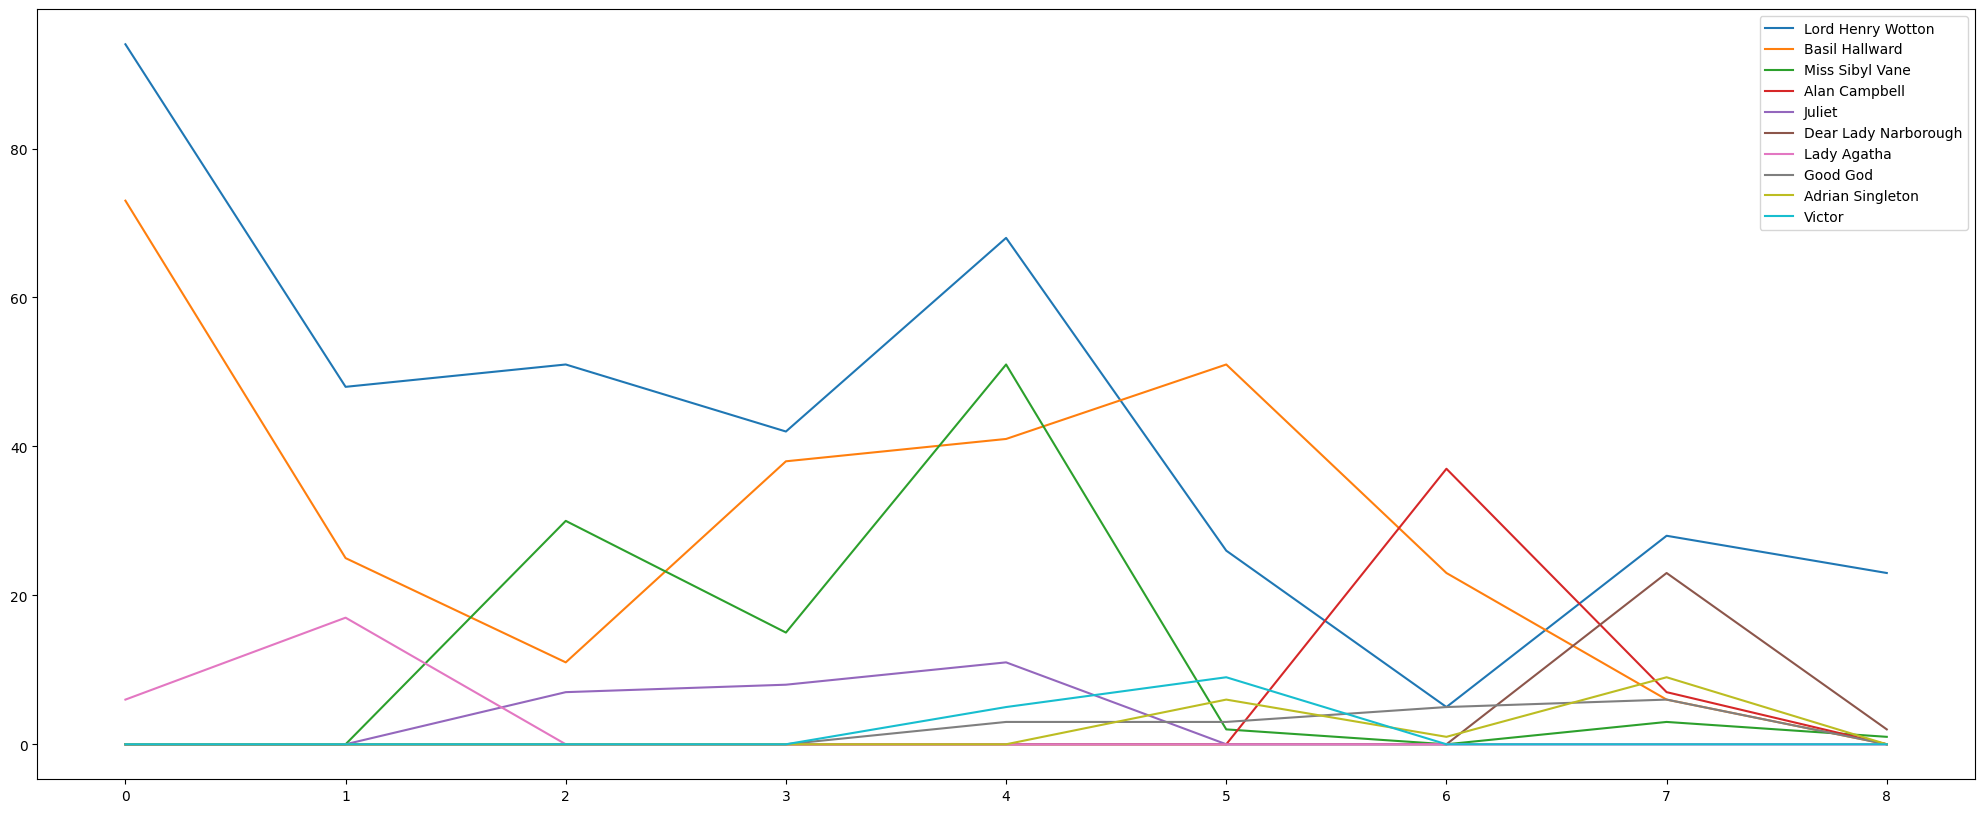

In [18]:
axis = np.arange(len(graphs))

for character, counts in top_10_characters.items():
    character_short_name = ' '.join(character.split()[:4])
    plt.plot(axis, counts, label=character_short_name)

plt.legend()
plt.rcParams['figure.figsize'] = (25., 10.)
plt.show()

In [14]:
sorted_keys = sorted(per_window_importances, key=lambda x: sum(per_window_importances[x]), reverse=True)

In [15]:
top_characters = {key: per_window_importances[key] for key in sorted_keys}

In [16]:
top_characters

{'Lord Henry Wotton': [94, 48, 51, 42, 68, 26, 5, 28, 23],
 'Basil Hallward': [73, 25, 11, 38, 41, 51, 23, 6, 0],
 'Miss Sibyl Vane': [0, 0, 30, 15, 51, 2, 0, 3, 1],
 'Alan Campbell': [0, 0, 0, 0, 0, 0, 37, 7, 0],
 'Juliet': [0, 0, 7, 8, 11, 0, 0, 0, 0],
 'Dear Lady Narborough': [0, 0, 0, 0, 0, 0, 0, 23, 2],
 'Lady Agatha': [6, 17, 0, 0, 0, 0, 0, 0, 0],
 'Good God': [0, 0, 0, 0, 3, 3, 5, 6, 0],
 'Adrian Singleton': [0, 0, 0, 0, 0, 6, 1, 9, 0],
 'Victor': [0, 0, 0, 0, 5, 9, 0, 0, 0],
 'Mr. Erskine of Treadley': [0, 13, 0, 0, 0, 0, 0, 0, 0],
 'Francis Osborne': [0, 0, 0, 0, 0, 3, 9, 0, 0],
 'Uncle George': [0, 11, 0, 0, 0, 0, 0, 0, 0],
 'Sir Thomas Burdon': [0, 9, 0, 0, 0, 0, 0, 0, 0],
 'Gladys': [0, 0, 0, 0, 0, 0, 0, 0, 9],
 'Poor Lady Brandon': [8, 0, 0, 0, 0, 0, 0, 0, 0],
 'Lord Fermor': [0, 8, 0, 0, 0, 0, 0, 0, 0],
 'the last Lord Kelso': [0, 6, 0, 0, 0, 1, 0, 0, 0],
 'Lady Margaret Devereux': [0, 7, 0, 0, 0, 0, 0, 0, 0],
 'Duchess': [0, 0, 0, 0, 0, 0, 0, 0, 6],
 'Lady Henry': [0, 0,

In [17]:
sorted_keys[:10]

['Lord Henry Wotton',
 'Basil Hallward',
 'Miss Sibyl Vane',
 'Alan Campbell',
 'Juliet',
 'Dear Lady Narborough',
 'Lady Agatha',
 'Good God',
 'Adrian Singleton',
 'Victor']